In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, linspace
from matplotlib.pyplot import plot
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from datetime import datetime , timedelta 
import time

path = ''

#phpmyadmin 에서 내보내기 -> db내용 csv파일로 저장

ModuleNotFoundError: No module named 'sklearn'

In [2]:
ble_tag_info_file = 'beacon_unique_info_tb.csv'                         # 수집되는 비콘의 고유 정보 저장 
ble_tag_data_file = 'beacon_rssi_rowdata_tb.csv'                             # BLE Tag 수집 데이터

beacon_info_df = pd.read_csv(path + ble_tag_info_file, delimiter=';')   #내보내기 형식 csv for excel

beacon_info_df = beacon_info_df.sort_values('minor')                    # minor 값 기준 오름차순 정렬 ( if minor == 0->ref.beacon )

beacon_info_df['actual_dist'] = [0.5 , 1.0 , 1.5 , 2.0 , 2.5 , 3.0 , 3.5 , \
4.0 , 4.5 , 5.0 , 6.0 , 7.0 , 8.0]                          # 각 ble tag 실제 배치 거리

print( beacon_info_df.head() )

ble_tag_minor_list = beacon_info_df['minor']

ref_ble_tag_minor = '0'     # 참조비콘

beacon_data_df = pd.read_csv(path + ble_tag_data_file, delimiter=';')
beacon_data_df = beacon_data_df.reset_index(drop=True)


print( beacon_data_df.head() )
print( beacon_data_df.tail() )


NameError: name 'pd' is not defined

In [ ]:
# 실제 거리, log distance, iBeacon 기반 추정거리, LR 기반 추정거리

# BLE TAG 별 실제거리 Dictionary
actual_dist_dict = { #key : value
    1:0.5,
    2:1.0,
    3:1.5,
    4:2.0,
    5:2.5,
    6:3.0,
    7:3.5,
    8:4.0,
    9:4.5,
    10:5.0,
    12:6.0,
    14:7.0,
    16:8.0,
}

txpower = -59 #진행중인 실험에서는 고정값

valid_minors = [1,2,3,4,5,6,7,8,9,10,12,14,16]
#  BLE TAG별 실제거리 매핑과 컬럼 추가
beacon_data_df['actual_dist'] = beacon_data_df['minor'].map(actual_dist_dict)

# BLE TAG 별 실제거리에 대한 log distance
beacon_data_df['log_d'] = np.log10(beacon_data_df['actual_dist'])

# BLE TAG 별 iBeacon 기반 추정거리
beacon_data_df['iBeacon_dist'] = 0.89976 * (beacon_data_df['rssi']/txpower) ** 7.7095 + 0.111



In [ ]:
beacon_data_df_grp = beacon_data_df.groupby('minor')
# print(beacon_data_df_grp.size())    # beacon별 raw data 수 

df_size_min = beacon_data_df_grp.size().min()   # beacon별 raw data size 최솟값
print(df_size_min)  # 84693

beacon_df_grp = [] 



for minor in valid_minors:
    beacon_df_grp.append(beacon_data_df_grp.get_group(minor)[:])  # beacon별 데이터 list에 추가
    beacon_data_df_grp.get_group(minor).to_csv(path + '/raw_data' + str((minor)) + '.csv')

temp = pd.DataFrame()
for i in range(len(beacon_df_grp)):
    temp = pd.concat([temp, pd.DataFrame(beacon_df_grp[i])])

# print(len(temp))    # total length
temp = temp.reset_index()
# print(temp.head())

beacon_data_df = temp.copy()
temp.head()


108222


,index,minor,rssi,time,actual_dist,log_d,iBeacon_dist
0,8,1,-55.0,2022-07-28 22:32:48,0.5,-0.30103,0.634684
1,13,1,-55.0,2022-07-28 22:32:49,0.5,-0.30103,0.634684
2,22,1,-56.0,2022-07-28 22:32:51,0.5,-0.30103,0.712726
3,31,1,-61.0,2022-07-28 22:32:53,0.5,-0.30103,1.274439
4,41,1,-55.0,2022-07-28 22:32:56,0.5,-0.30103,0.634684


In [ ]:
# Linear Regression Model
rssi = pd.DataFrame(beacon_data_df['rssi']) # pd.DataFrame 씌워줘야 아래에서 shape 오류 안남
log_d = pd.DataFrame(beacon_data_df['log_d'])
actual_dist = pd.DataFrame(beacon_data_df['actual_dist'])

rssi = rssi.values
actual_dist = actual_dist.values

# Dataset을 train data와 test data로 구분 / random_state는 호출할 때마다 동일하게 train/test 용 데이터 셋 분할위한 난수 발생 값
x_train, x_test, y_train, y_test = train_test_split(rssi, actual_dist, train_size=0.8, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

model = LinearRegression() # 모델 선정
model.fit(pd.DataFrame(x_train),pd.DataFrame(y_train)) # 모델 학습
print('기울기:', model.coef_)
print('y절편:', model.intercept_)

accuracy = model.score(x_test,y_test) # model 성능평가
print('정확도:',accuracy)

# x_test를 이용해 목표값 예측
y_pred = model.predict(x_test) # 학습된 모델에 x_test 데이터 입력 -> y_pred에 예측 값이 담김
# print(y_pred)

# 실제값과 예측값 간의 오차 확인 (RMSE)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:',RMSE)

# BLE TAG 별 LR 기반 추정거리 est_dist 업데이트
beacon_data_df['est_dist'] = (pd.DataFrame((model.coef_ * np.array(beacon_data_df['rssi']) + model.intercept_))).transpose()
#print(beacon_data_df.head())


from sklearn.metrics import mean_squared_error ,r2_score , mean_squared_log_error
r2 = r2_score(y_test,y_pred)
print('R2 : ',r2)

for i in range(0, len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE :", rmsle)


#beacon_data_df.to_csv(path+'LR_predict Data.csv')



(1608973, 1)
(1608973, 1)
(402244, 1)
(402244, 1)
기울기: [[-0.26411015]]
y절편: [-15.81177071]
정확도: 0.5436532536181715
RMSE: 1.5053973870861783
R2 :  0.5436532536181715
RMSLE : 0.33671520307545894


In [ ]:
#####################
#  data split test  #
#####################

raw_data_read = pd.read_csv(path + 'beacon_rssi_rowdata_tb.csv', delimiter=';')

raw_data_read = raw_data_read.loc[:] # 1분짜리 데이터

beacon_split_info = np.array(raw_data_read)

#print(beacon_split_info)

minor_cnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
five_avg  = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
three_avg = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

five_cnt_list = []
three_cnt_list = []

five_sec = timedelta(seconds= 5)
three_sec = timedelta(seconds= 3)

for kk in range(0, len(beacon_split_info)):
    beacon_split_info[kk][2] = datetime.strptime(beacon_split_info[kk][2], '%Y-%m-%d %H:%M:%S' )


std_time = beacon_split_info[0][2]
print(std_time)
for kk in range(0, len(beacon_split_info)):
    five_avg[ int(beacon_split_info[kk][0]-1) ] += 1
    if std_time+five_sec > beacon_split_info[kk][2]:
        minor_cnt[beacon_split_info[kk][0]-1] += 1
    else:
        std_time = beacon_split_info[kk][2]
        print(std_time)
        five_cnt_list.append(minor_cnt)
        minor_cnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        minor_cnt[beacon_split_info[kk][0]-1] += 1
five_cnt_list = np.array(five_cnt_list)


std_time = beacon_split_info[0][2]
print(std_time)
for kk in range(0, len(beacon_split_info)):
    three_avg[beacon_split_info[kk][0]-1] += 1
    if std_time+three_sec > beacon_split_info[kk][2]:
        minor_cnt[beacon_split_info[kk][0]-1] += 1
    else:
        std_time = beacon_split_info[kk][2]
        #print(std_time)
        three_cnt_list.append(minor_cnt)
        minor_cnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        minor_cnt[beacon_split_info[kk][0]-1] += 1
print(std_time)
three_cnt_list = np.array(three_cnt_list)


print(five_cnt_list)
print('---------------')
print(three_cnt_list)


print((five_cnt_list))
print((three_cnt_list))


for kk in range(0 , len(five_avg)):
    five_avg[kk] = round(five_avg[kk]/len(five_cnt_list),2)

    
for kk in range(0 , len(three_avg)):
    three_avg[kk] = round(three_avg[kk]/len(three_cnt_list),2)
    

print(five_avg)

print(three_avg)


2022-07-28 22:32:45
2022-07-28 22:32:50
2022-07-28 22:32:55
2022-07-28 22:33:00
2022-07-28 22:33:05
2022-07-28 22:33:10
2022-07-28 22:33:15
2022-07-28 22:33:20
2022-07-28 22:33:25
2022-07-28 22:33:30
2022-07-28 22:33:35
2022-07-28 22:33:40
2022-07-28 22:33:45
2022-07-28 22:33:50
2022-07-28 22:33:55
2022-07-28 22:34:00
2022-07-28 22:34:05
2022-07-28 22:34:10
2022-07-28 22:34:15
2022-07-28 22:34:20
2022-07-28 22:34:25
2022-07-28 22:34:30
2022-07-28 22:34:35
2022-07-28 22:34:40
2022-07-28 22:34:45
2022-07-28 22:34:50
2022-07-28 22:34:55
2022-07-28 22:35:00
2022-07-28 22:35:05
2022-07-28 22:35:10
2022-07-28 22:35:15
2022-07-28 22:35:20
2022-07-28 22:35:25
2022-07-28 22:35:30
2022-07-28 22:35:35
2022-07-28 22:35:40
2022-07-28 22:35:45
2022-07-28 22:35:50
2022-07-28 22:35:55
2022-07-28 22:36:00
2022-07-28 22:36:05
2022-07-28 22:36:10
2022-07-28 22:36:15
2022-07-28 22:36:20
2022-07-28 22:36:25
2022-07-28 22:36:30
2022-07-28 22:36:35
2022-07-28 22:36:40
2022-07-28 22:36:45
2022-07-28 22:36:50


In [ ]:
minor = [1,2,3,4,5,6,7,8,9,10,12,14,16]
#minor = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

five_avg.remove(0.0)
five_avg.remove(0.0)
five_avg.remove(0.0)



three_avg.remove(0.0)
three_avg.remove(0.0)
three_avg.remove(0.0)



[2.58, 2.43, 2.58, 2.53, 2.49, 2.41, 1.59, 2.46, 2.34, 1.83, 1.95, 2.18, 2.13]
[1.55, 1.46, 1.55, 1.52, 1.5, 1.45, 0.95, 1.48, 1.41, 1.1, 1.17, 1.31, 1.28]


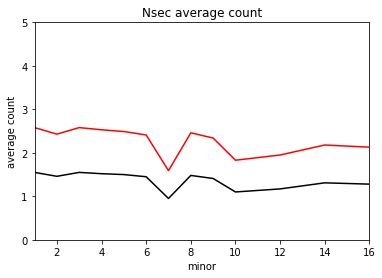

In [ ]:
print(five_avg)
print(three_avg)
plt.figure()
plt.plot(minor,five_avg, 'r-')
plt.plot(minor,three_avg  , 'k-')
plt.title('Nsec average count')
plt.xlabel('minor')
plt.xlim([1,16])
plt.ylim([0,5])
plt.ylabel('average count')
plt.savefig('Nsec avgerage count.png')
plt.show()



In [ ]:
# Linear Regression Model Visualization
plt.figure(dpi=150)
plt.plot(rssi.values,log_d.values,'k.',alpha=.01 )
plt.plot(x_test,y_pred,'r-')
plt.xlabel('RSSI')
plt.ylabel('log(d)')
#plt.savefig('short_range_RSSI-Log(d).png')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

<Figure size 900x600 with 0 Axes>

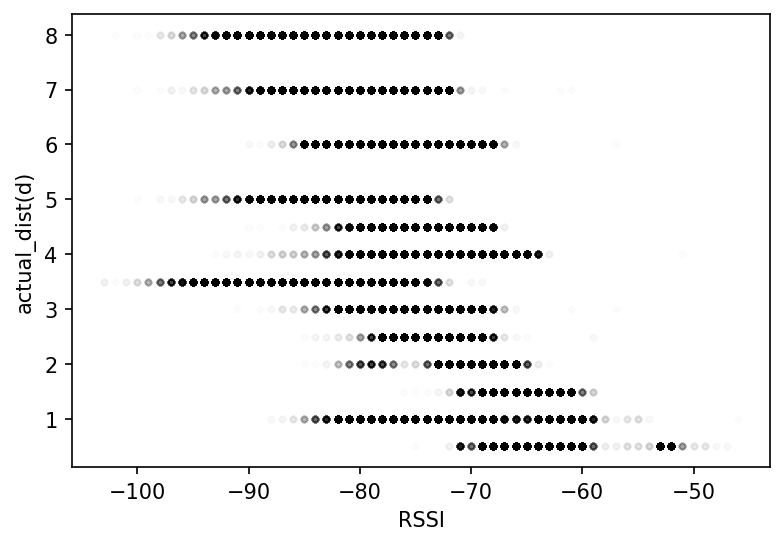

In [ ]:
# Linear Regression Model Visualization
plt.figure(dpi=150)
plt.plot(rssi,actual_dist,'k.' ,alpha=.01)
#plt.plot(x_test.values,y_pred,'r-')
plt.xlabel('RSSI')
plt.ylabel('actual_dist(d)')
#plt.savefig('short_range_RSSI-Log(d).png')
plt.show()

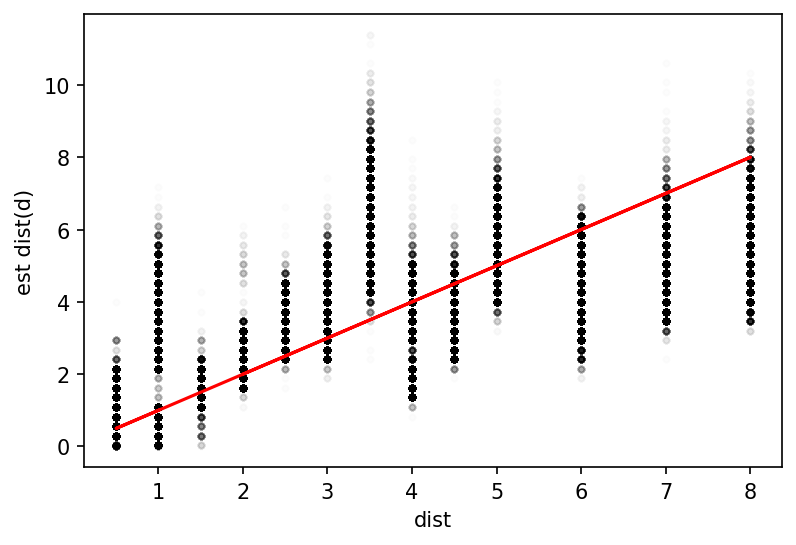

In [ ]:
# Linear Regression Model Visualization
plt.figure(dpi=150)
plt.plot(y_test,y_pred,'k.' ,alpha=.01)
plt.plot(y_test,y_test,'r-' )
#plt.plot(x_test.values,y_pred,'r-')
plt.xlabel('dist')
plt.ylabel('est dist(d)')
#plt.savefig('short_range_RSSI-Log(d).png')
plt.show()

In [ ]:
iBeacon_train, iBeacon_test = train_test_split(pd.DataFrame(beacon_data_df['iBeacon_dist']), train_size=0.75, random_state=42)
LR_train, LR_test = train_test_split(pd.DataFrame(beacon_data_df['est_dist']),train_size=0.75, random_state=42)
actual_train, actual_test = train_test_split(pd.DataFrame(beacon_data_df['actual_dist']), train_size=0.75, random_state=42)

iBeacon_RMSE = np.sqrt(mean_squared_error(iBeacon_test,actual_test))
LR_RMSE = np.sqrt(mean_squared_error(LR_test,actual_test))

print('iBeacon-based RMSE:',iBeacon_RMSE)
print('LR-based RMSE:',LR_RMSE)

In [ ]:
# # 임의로 값 비교하기 위한 부분
# each_beacon_group = beacon_data_df.groupby(['minor']).mean()
# each_group_error = np.abs(each_beacon_group['actual_dist'] - each_beacon_group['est_dist'])
# each_group_error2 = np.abs(each_beacon_group['actual_dist'] - each_beacon_group['iBeacon_dist'])
# # each_group_error = (each_beacon_group['actual_dist'] - each_beacon_group['est_dist'])
# # each_group_error2 = (each_beacon_group['actual_dist'] - each_beacon_group['iBeacon_dist'])

# # print(each_beacon_group)
# # print(each_group_error)
# # print(each_group_error2)
# print('LR-based:',each_group_error.mean()) # LR-based 거리추정 모델 오차 평균
# print('iBeacon-based:',each_group_error2.mean()) # iBeacon-based 거리추정 모델 오차 평균
# # print(ble_tag_minor_list)